In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# !unzip '/content/drive/MyDrive/Colab Notebooks/Warm-ups/dataset.zip' -d '/content/drive/MyDrive/Colab Notebooks/Warm-ups'

In [2]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.to(torch.float32).repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

In [3]:
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

In [4]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([3, 224, 224])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 422


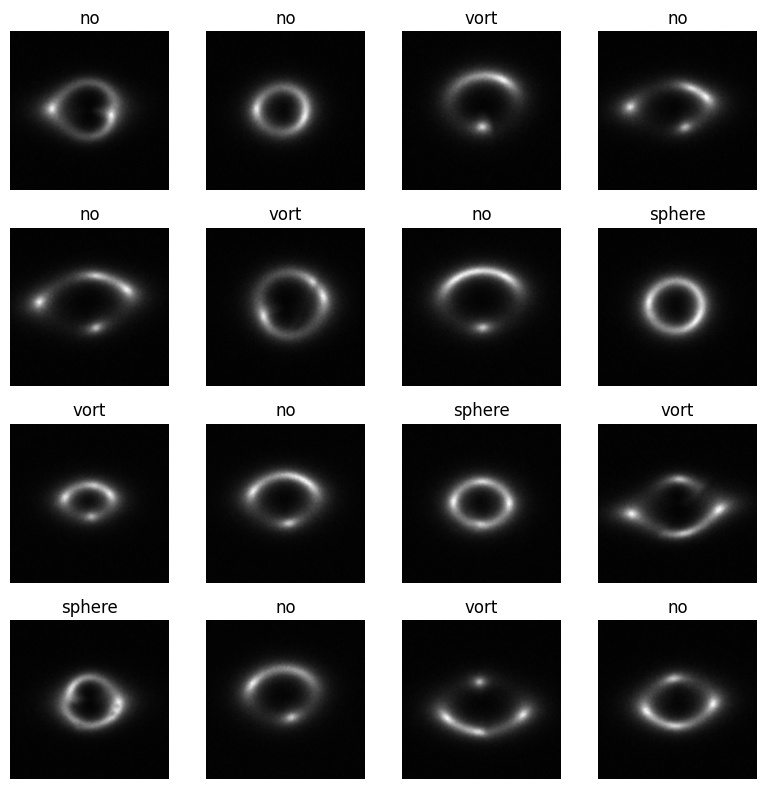

In [6]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Copy this
            outputs = model(inputs)
            logits = outputs.logits
            preds = F.softmax(logits, dim=1)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            train_corrects += torch.sum(idx == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                logits = outputs.logits
                preds = F.softmax(logits, dim=1)
                loss = criterion(preds, labels)

                val_loss += loss.item() * inputs.size(0)
                _, idx = torch.max(preds, 1)
                val_corrects += torch.sum(idx == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Step the scheduler
        scheduler.step(val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '../best_param_ViT.pt')

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}')
        print(f'\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}')

        model.load_state_dict(torch.load('../best_param_ViT.pt'))

    return model

In [17]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits
            preds = F.softmax(logits, dim=1)
            loss = criterion(preds, labels)

            total_loss += loss.item() * inputs.size(0)
            _, idx = torch.max(preds, 1)
            total_corrects += torch.sum(idx == labels).item()

            y_pred_probs.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')

    print('Outputs:', outputs)
    print('Logits:', logits)
    print('Predictions:', preds)
    print('Idx:', idx)
    print('Labels:', labels)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [11]:
from transformers import CvtForImageClassification, CvtConfig

configuration = CvtConfig()
model = CvtForImageClassification(configuration)
model.config.id2label = {'0': 'no', '1': 'sphere', '2': 'vort'}
model.config.label2id = {'no': 0, 'sphere': 1, 'vort': 2}
model.classifier = nn.Linear(384, 3, True)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()

configuration = model.config
print(configuration)
model

CvtConfig {
  "attention_drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "cls_token": [
    false,
    false,
    true
  ],
  "depth": [
    1,
    2,
    10
  ],
  "drop_path_rate": [
    0.0,
    0.0,
    0.1
  ],
  "drop_rate": [
    0.0,
    0.0,
    0.0
  ],
  "embed_dim": [
    64,
    192,
    384
  ],
  "id2label": {
    "0": "no",
    "1": "sphere",
    "2": "vort"
  },
  "initializer_range": 0.02,
  "kernel_qkv": [
    3,
    3,
    3
  ],
  "label2id": {
    "no": 0,
    "sphere": 1,
    "vort": 2
  },
  "layer_norm_eps": 1e-12,
  "mlp_ratio": [
    4.0,
    4.0,
    4.0
  ],
  "model_type": "cvt",
  "num_channels": 3,
  "num_heads": [
    1,
    3,
    6
  ],
  "padding_kv": [
    1,
    1,
    1
  ],
  "padding_q": [
    1,
    1,
    1
  ],
  "patch_padding": [
    2,
    1,
    1
  ],
  "patch_sizes": [
    7,
    3,
    3
  ],
  "patch_stride": [
    4,
    2,
    2
  ],
  "qkv_bias": [
    true,
    true,
    true
  ],
  "qkv_projection_method": [
    "dw_bn",
    "dw_b

CvtForImageClassification(
  (cvt): CvtModel(
    (encoder): CvtEncoder(
      (stages): ModuleList(
        (0): CvtStage(
          (embedding): CvtEmbeddings(
            (convolution_embeddings): CvtConvEmbeddings(
              (projection): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
              (normalization): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (layers): Sequential(
            (0): CvtLayer(
              (attention): CvtAttention(
                (attention): CvtSelfAttention(
                  (convolution_projection_query): CvtSelfAttentionProjection(
                    (convolution_projection): CvtSelfAttentionConvProjection(
                      (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
model = train_model(model, criterion, optimizer, scheduler, num_epochs=20)
print('Finished')

Epoch 1/20:
	Train Loss: 1.1217	Train Acc: 0.3314
	Val Loss: 1.1017	Val Acc: 0.3293
Epoch 2/20:
	Train Loss: 1.1034	Train Acc: 0.3281
	Val Loss: 1.0995	Val Acc: 0.3310
Epoch 3/20:
	Train Loss: 1.1008	Train Acc: 0.3360
	Val Loss: 1.1004	Val Acc: 0.3310
Epoch 4/20:
	Train Loss: 1.1003	Train Acc: 0.3377
	Val Loss: 1.1014	Val Acc: 0.3293
Epoch 5/20:
	Train Loss: 1.1009	Train Acc: 0.3307
	Val Loss: 1.1007	Val Acc: 0.3310
Epoch 6/20:
	Train Loss: 1.1001	Train Acc: 0.3342
	Val Loss: 1.0985	Val Acc: 0.3397
Epoch 7/20:
	Train Loss: 1.0997	Train Acc: 0.3330
	Val Loss: 1.1005	Val Acc: 0.3293
Epoch 8/20:
	Train Loss: 1.0999	Train Acc: 0.3330
	Val Loss: 1.0985	Val Acc: 0.3397
Epoch 9/20:
	Train Loss: 1.0998	Train Acc: 0.3337
	Val Loss: 1.0986	Val Acc: 0.3397
Epoch 10/20:
	Train Loss: 1.0992	Train Acc: 0.3374
	Val Loss: 1.0985	Val Acc: 0.3397
Epoch 11/20:
	Train Loss: 1.0993	Train Acc: 0.3351
	Val Loss: 1.0991	Val Acc: 0.3290
Epoch 12/20:
	Train Loss: 1.0995	Train Acc: 0.3273
	Val Loss: 1.0987	Val A

KeyboardInterrupt: 

In [16]:
model.load_state_dict(torch.load('../best_param_ViT.pt'))

<All keys matched successfully>

Outputs: ImageClassifierOutputWithNoAttention(loss=None, logits=tensor([[0.8053, 1.0113, 0.9534],
        [0.8085, 1.0456, 0.9630],
        [0.8007, 0.9911, 0.9446],
        [0.8149, 1.0818, 0.9616],
        [0.8073, 1.0451, 0.9517],
        [0.8129, 1.0305, 0.9604],
        [0.8112, 1.0646, 0.9552],
        [0.8107, 1.0198, 0.9569],
        [0.8055, 1.0291, 0.9440],
        [0.8217, 1.0677, 0.9599],
        [0.8191, 1.0955, 0.9453],
        [0.8089, 1.0312, 0.9577]], device='cuda:0'), hidden_states=None)
Logits: tensor([[0.8053, 1.0113, 0.9534],
        [0.8085, 1.0456, 0.9630],
        [0.8007, 0.9911, 0.9446],
        [0.8149, 1.0818, 0.9616],
        [0.8073, 1.0451, 0.9517],
        [0.8129, 1.0305, 0.9604],
        [0.8112, 1.0646, 0.9552],
        [0.8107, 1.0198, 0.9569],
        [0.8055, 1.0291, 0.9440],
        [0.8217, 1.0677, 0.9599],
        [0.8191, 1.0955, 0.9453],
        [0.8089, 1.0312, 0.9577]], device='cuda:0')
Predictions: tensor([[0.2951, 0.3626, 0.3422],
        

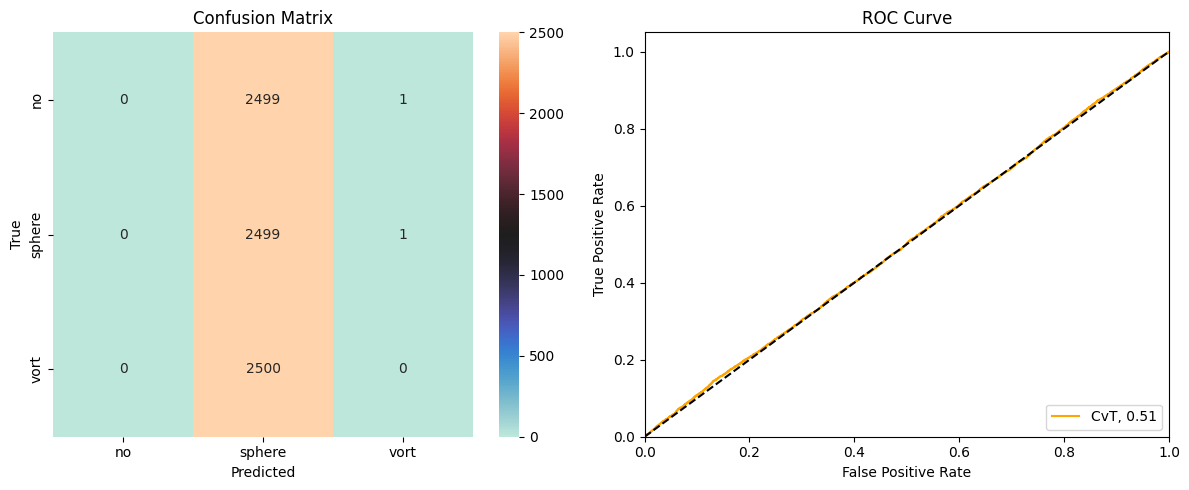

In [18]:
evaluate_model(model, criterion, 'CvT')